In [5]:
!pip install brian2
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

plasticity_on = True

N_exc, N_inh = 8000, 2000
p = 0.02
tau_m, tau_syn_exc, tau_syn_inh = 20*ms, 5*ms, 10*ms
V_thr, V_reset, E_leak = -50*mV, -60*mV, -70*mV
I_b, g_bar = 200*pA, 3*nS


tau_stdp = 20*ms
eta = 1e-2 if plasticity_on else 0
alpha = 0.2
w_max = 10.0
sim_time = 100000*ms if plasticity_on else 1000*ms


neuron_eqs = '''
dv/dt = (g_leak*(E_leak - v) + I_exc + I_inh + I_b) / C_m : volt (unless refractory)
I_exc = g_exc * (0*mV - v) : amp
I_inh = g_inh * (-80*mV - v) : amp
dg_exc/dt = -g_exc / tau_syn_exc : siemens
dg_inh/dt = -g_inh / tau_syn_inh : siemens
dx/dt = -x / tau_stdp : 1  # Synaptic trace
'''
C_m = 200*pF
g_leak = C_m / tau_m

start_scope()


G_exc = NeuronGroup(N_exc, neuron_eqs, threshold='v > V_thr',
                    reset='v = V_reset; x += 1', refractory=5*ms, method='euler')
G_inh = NeuronGroup(N_inh, neuron_eqs, threshold='v > V_thr',
                    reset='v = V_reset; x += 1', refractory=5*ms, method='euler')

G_exc.v = 'V_reset + rand() * (V_thr - V_reset)'
G_inh.v = 'V_reset + rand() * (V_thr - V_reset)'


S_EE = Synapses(G_exc, G_exc, 'w : 1', on_pre='g_exc_post += w*g_bar'); S_EE.connect(p=p); S_EE.w = 0.03
S_EI = Synapses(G_exc, G_inh, 'w : 1', on_pre='g_exc_post += w*g_bar'); S_EI.connect(p=p); S_EI.w = 0.03
S_II = Synapses(G_inh, G_inh, 'w : 1', on_pre='g_inh_post += w*g_bar'); S_II.connect(p=p); S_II.w = 1.0


if plasticity_on:
    pre_logic = 'g_inh_post += w*g_bar; w = clip(w + eta * (x_post - alpha), 0, w_max)'
    post_logic = 'w = clip(w + eta * x_pre, 0, w_max)'
else:
    pre_logic = 'g_inh_post += w*g_bar'
    post_logic = ''

S_IE = Synapses(G_inh, G_exc, 'w : 1', on_pre=pre_logic, on_post=post_logic)
S_IE.connect(p=p)
S_IE.w = 0.0

P_input_e = PoissonInput(G_exc, 'g_exc', N=100, rate=5*Hz, weight=0.1*g_bar)
P_input_i = PoissonInput(G_inh, 'g_exc', N=100, rate=5*Hz, weight=0.1*g_bar)

stat_mon = StateMonitor(G_exc, ['v', 'I_exc', 'I_inh'], record=0)
weight_mon = StateMonitor(S_IE, 'w', record=range(10))
spikes_e = SpikeMonitor(G_exc)
rate_mon = PopulationRateMonitor(G_exc)

run(sim_time)

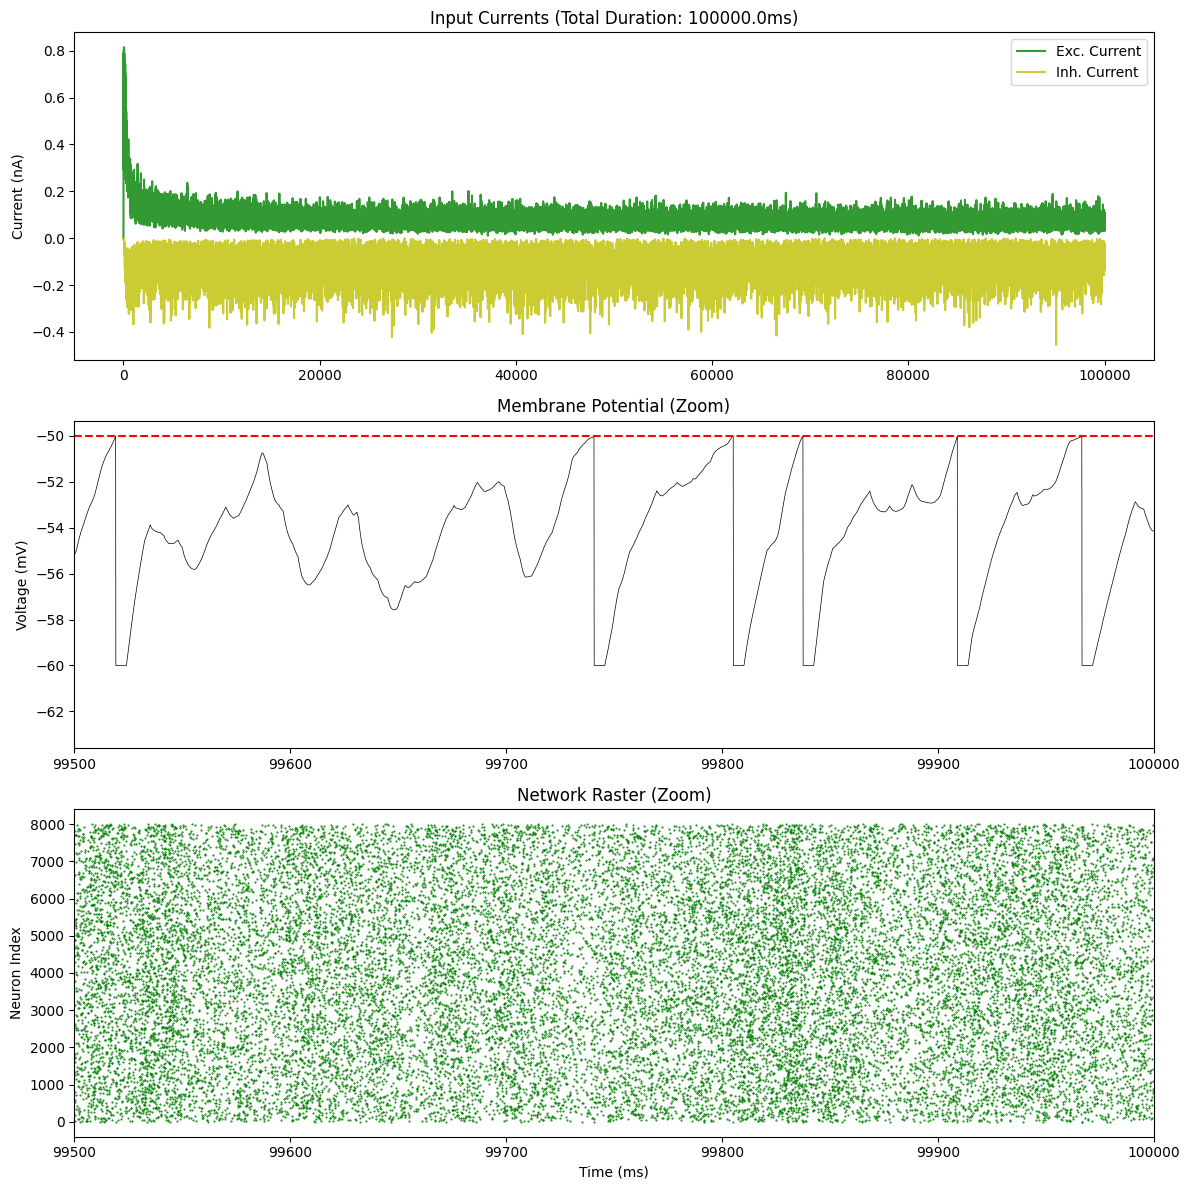

In [6]:

current_sim_time_ms = sim_time / ms
zoom_window = 500
t_start = max(0, current_sim_time_ms - zoom_window)
t_end = current_sim_time_ms

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(stat_mon.t/ms, stat_mon.I_exc[0]/nA, 'g', label='Exc. Current', alpha=0.8)
ax[0].plot(stat_mon.t/ms, stat_mon.I_inh[0]/nA, 'y', label='Inh. Current', alpha=0.8)
ax[0].set(ylabel='Current (nA)', title=f'Input Currents (Total Duration: {current_sim_time_ms}ms)')
ax[0].legend()

ax[1].plot(stat_mon.t/ms, stat_mon.v[0]/mV, 'k', linewidth=0.5)
ax[1].axhline(V_thr/mV, color='r', linestyle='--')
ax[1].set(xlim=(t_start, t_end), ylabel='Voltage (mV)', title='Membrane Potential (Zoom)')

mask = (spikes_e.t/ms > t_start)
ax[2].plot(spikes_e.t[mask]/ms, spikes_e.i[mask], '.g', markersize=1)
ax[2].set(xlim=(t_start, t_end), xlabel='Time (ms)', ylabel='Neuron Index', title='Network Raster (Zoom)')

plt.tight_layout()
plt.show()

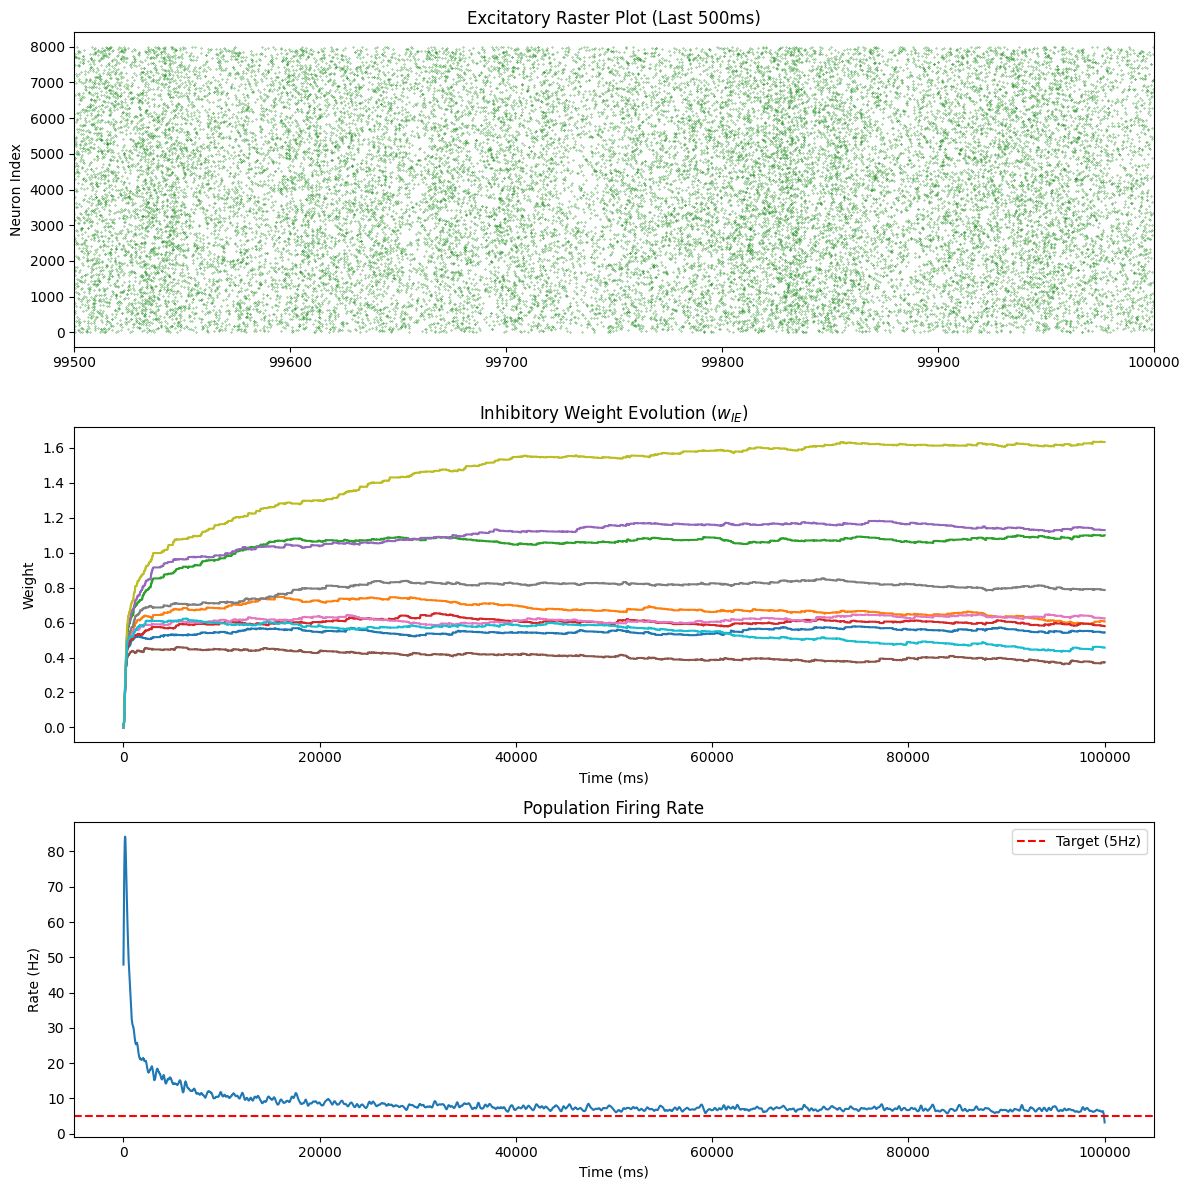

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

t_end = sim_time / ms
ax[0].plot(spikes_e.t/ms, spikes_e.i, '.g', markersize=0.5)
ax[0].set(xlim=(t_end-500, t_end), title="Excitatory Raster Plot (Last 500ms)", ylabel="Neuron Index")


if 'weight_mon' in locals():
    ax[1].plot(weight_mon.t/ms, weight_mon.w.T)
ax[1].set(title="Inhibitory Weight Evolution ($w_{IE}$)", ylabel="Weight", xlabel="Time (ms)")

ax[2].plot(rate_mon.t/ms, rate_mon.smooth_rate(window='gaussian', width=100*ms)/Hz)
ax[2].axhline(5, color='r', ls='--', label='Target (5Hz)')
ax[2].set(title="Population Firing Rate", ylabel="Rate (Hz)", xlabel="Time (ms)")
ax[2].legend()

plt.tight_layout()
plt.show()

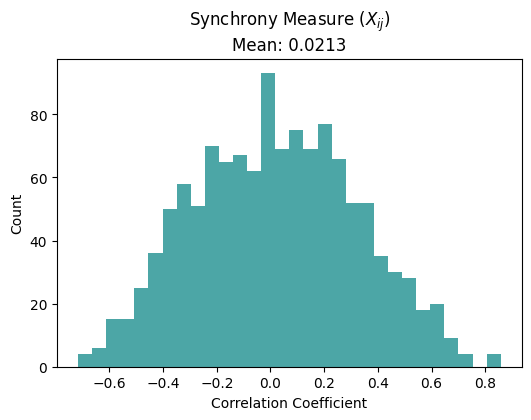

In [8]:
def calculate_vogels_correlation(spike_monitor, sim_time, num_neurons=50, window_size=1.0*second):
    t_end = sim_time
    t_start = max(0*ms, t_end - window_size)

    trains = spike_monitor.spike_trains()
    active = [i for i in trains.keys() if len(trains[i][(trains[i] >= t_start) & (trains[i] < t_end)]) > 2]

    if len(active) < 2:
        print("Warning: Not enough active neurons in the window to calculate correlation.")
        return np.array([0])

    n_neurons = min(num_neurons, len(active))
    selected = np.random.choice(active, n_neurons, replace=False)

    dt = 1*ms
    tau1, tau2 = 50*ms, 200*ms
    t_kernel = np.arange(-500, 500) * ms
    kernel = (np.exp(-np.abs(t_kernel)/tau1)/tau1 - np.exp(-np.abs(t_kernel)/tau2)/tau2)
    kernel /= np.sum(np.abs(kernel))

    bins = np.arange(t_start/ms, t_end/ms + dt/ms, dt/ms)

    filtered_signals = []
    for i in selected:
        spikes_in_window = trains[i][(trains[i] >= t_start) & (trains[i] < t_end)]
        binned_spikes, _ = np.histogram(spikes_in_window/ms, bins=bins)
        filtered_signals.append(np.convolve(binned_spikes, kernel, mode='same'))

    corr_matrix = np.corrcoef(filtered_signals)
    correlations = corr_matrix[np.triu_indices(n_neurons, k=1)]

    return correlations

corrs = calculate_vogels_correlation(spikes_e, sim_time=sim_time)

plt.figure(figsize=(6, 4))
plt.hist(corrs, bins=30, color='teal', alpha=0.7)
plt.title(f"Synchrony Measure ($X_{{ij}}$)\nMean: {np.mean(corrs):.4f}")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Count")
plt.show()

--- Final Step 3 Results ---
Detailed Balance Correlation (Peak): 0.0868
Biological Lag (I follows E): 0.00 ms


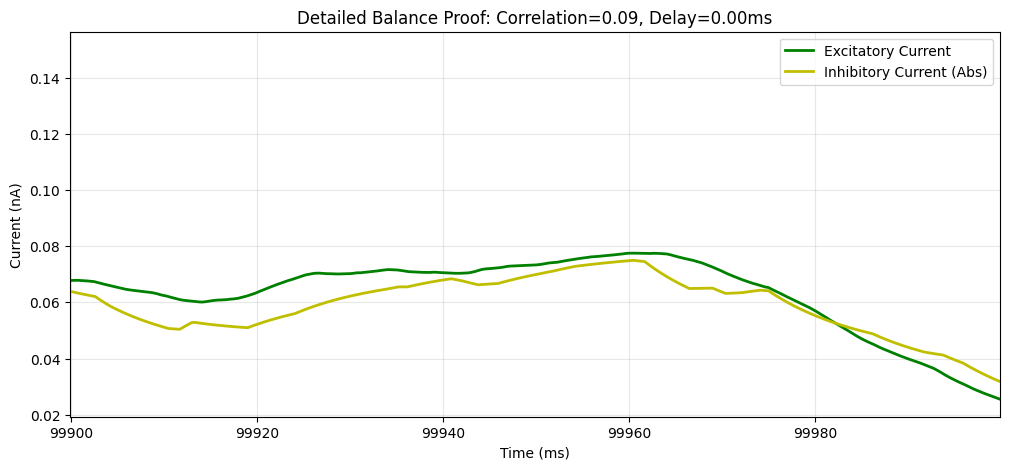

In [9]:
from scipy import signal

t_mask = stat_mon.t > (sim_time - 1.0*second)
i_exc = stat_mon.I_exc[0][t_mask] / nA
i_inh = np.abs(stat_mon.I_inh[0][t_mask] / nA)
time_ms = stat_mon.t[t_mask] / ms


win_size = int(50*ms / defaultclock.dt)
i_exc_smooth = np.convolve(i_exc, np.ones(win_size)/win_size, mode='same')
i_inh_smooth = np.convolve(i_inh, np.ones(win_size)/win_size, mode='same')


sig_e = i_exc_smooth - np.mean(i_exc_smooth)
sig_i = i_inh_smooth - np.mean(i_inh_smooth)


corr_values = signal.correlate(sig_e, sig_i, mode='same')
lags = signal.correlation_lags(len(sig_e), len(sig_i), mode='same')
lags_ms = lags * (defaultclock.dt / ms)


bio_mask = (lags_ms > -20) & (lags_ms < 20)
best_lag_idx = np.argmax(corr_values[bio_mask])
best_lag_ms = lags_ms[bio_mask][best_lag_idx]


i_inh_shifted = np.roll(i_inh_smooth, -int(best_lag_ms / (defaultclock.dt/ms)))
peak_corr = np.corrcoef(i_exc_smooth[100:-100], i_inh_shifted[100:-100])[0, 1]

print(f"--- Final Step 3 Results ---")
print(f"Detailed Balance Correlation (Peak): {peak_corr:.4f}")
print(f"Biological Lag (I follows E): {best_lag_ms:.2f} ms")


plt.figure(figsize=(12, 5))
zoom_start, zoom_end = time_ms[-1]-100, time_ms[-1]

plt.plot(time_ms, i_exc_smooth, 'g', linewidth=2, label='Excitatory Current')
plt.plot(time_ms, i_inh_smooth, 'y', linewidth=2, label='Inhibitory Current (Abs)')

plt.xlim(zoom_start, zoom_end)
plt.title(f"Detailed Balance Proof: Correlation={peak_corr:.2f}, Delay={best_lag_ms:.2f}ms")
plt.xlabel("Time (ms)")
plt.ylabel("Current (nA)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Memory Imprinted: Excitatory weights in neurons 0 to 500 increased by 5x
Simulating 20.0s for Re-balancing...


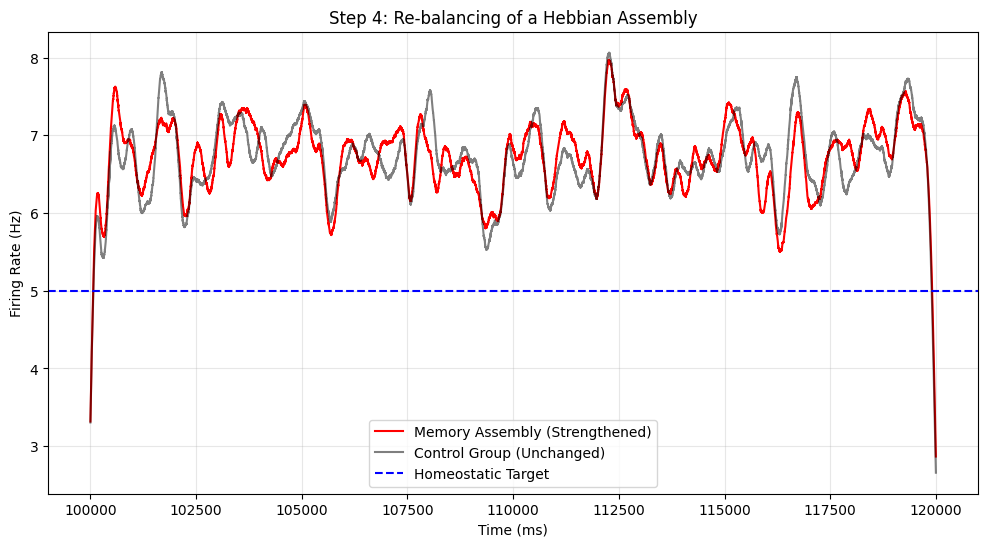

Final Assembly Rate: 0.00


In [10]:
rho_0 = 5*Hz
assembly_start = 0
assembly_end = 500
assembly_indices = np.arange(assembly_start, assembly_end)

strengthening_factor = 5

is_in_assembly = np.zeros(N_exc, dtype=bool)
is_in_assembly[assembly_indices] = True

S_EE.w[is_in_assembly[S_EE.i] & is_in_assembly[S_EE.j]] *= strengthening_factor

print(f"Memory Imprinted: Excitatory weights in neurons {assembly_start} to {assembly_end} increased by {strengthening_factor}x")

assembly_group = G_exc[assembly_start:assembly_end]
assembly_rate_mon = PopulationRateMonitor(assembly_group)

control_start = 1000
control_end = 1500
control_group = G_exc[control_start:control_end]
control_rate_mon = PopulationRateMonitor(control_group)


rebalance_time = 20000*ms
print(f"Simulating {rebalance_time/second}s for Re-balancing...")
run(rebalance_time)

plt.figure(figsize=(12, 6))

plt.plot(assembly_rate_mon.t/ms, assembly_rate_mon.smooth_rate(window='gaussian', width=100*ms)/Hz,
         'r', label='Memory Assembly (Strengthened)')
plt.plot(control_rate_mon.t/ms, control_rate_mon.smooth_rate(window='gaussian', width=100*ms)/Hz,
         'k', alpha=0.5, label='Control Group (Unchanged)')

plt.axhline(rho_0/Hz, color='b', ls='--', label='Homeostatic Target')
plt.title("Step 4: Re-balancing of a Hebbian Assembly")
plt.xlabel("Time (ms)")
plt.ylabel("Firing Rate (Hz)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Final Assembly Rate: {assembly_rate_mon.rate[-1]:.2f}")